In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import xgboost as xgb

import os
from joblib import Parallel, delayed

import utils, data_utils

In [2]:
def make_reg_features(icat1, icat2, r_min=0, r_max=99, k=30):
    
    # neighbor finder    
    pos = ['RA','DEC']
    pri_idx, sec_idx, separation = utils.kdt_neighbor_finder(icat1[pos].to_numpy(), 
                                                             icat2[pos].to_numpy(), 
                                                             r_min=r_min, r_max=r_max, k=k)
    
    # concatenate secondary and primary catalog for regression predicter
    sec_cat = icat2.iloc[sec_idx].reset_index(drop=True)
    sec_cat = sec_cat.rename(columns={f:f+'_input_s' for f in icat2.columns})
    
    pri_cat = icat1.iloc[pri_idx].reset_index(drop=True)
    pri_cat = pri_cat.rename(columns={f:f+'_input_p' for f in icat1.columns})

    response_features = pd.concat((pri_cat,sec_cat),axis=1)
    response_features['distance'] = separation
    
    return response_features
    

def icat2reg(icat_pri,icat_sec,model):

    # match neighbors, make pair catalog and select sources
    reg_features_i = make_reg_features(icat_pri, icat_sec, r_max=r_max, k=30)
    reg_features_i = data_utils.source_select_reg(reg_features_i)

    reg_features_i['distance'] *= 3600

    # rescale everything
    reg_features_i = data_utils.rescale(reg_features_i,zero_mag=zero_point,
                                        pixel_rms=pixel_rms,pixel_size=pixel_size,
                                        psf_fwhm=psf_fwhm,moffat_beta=moffat_beta)

    # emulator responses
    response_pred = data_utils.xgb_pred(model,reg_features_i)

    # reverse standardization
    reg_features_i['response'] = data_utils.reverse_standardize(response_pred, y_mean, y_std)
    return reg_features_i

def icat2cla(icat_pri,icat_sec,model,cla_k=2):

    # make a copy for classification
    reg_features_i_cla = make_reg_features(icat_pri, icat_sec, r_min=0., r_max=999, k=cla_k) # r_max=99 makes sure there is at least one neighbour; this is important
    idx_cla = np.where(reg_features_i_cla['distance']>r_max_cla)[0]
    reg_features_i_cla.loc[idx_cla,classification_names_sec] = np.nan
    reg_features_i_cla.loc[idx_cla,classification_names_sec] = np.nan
    reg_features_i_cla['neighbored'] = np.full(reg_features_i_cla.shape[0],True)
    reg_features_i_cla.loc[idx_cla,'neighbored'] = False

    reg_features_i_cla['distance'] *= 3600

    # rescale everything
    reg_features_i_cla = data_utils.rescale(reg_features_i_cla,zero_mag=zero_point,
                                                        pixel_rms=pixel_rms,pixel_size=pixel_size,
                                                        psf_fwhm=psf_fwhm,moffat_beta=moffat_beta)
    
    # emulator detections 
    detect_pred = data_utils.xgb_pred(model, reg_features_i_cla)
    reg_features_i_cla['detection'] = detect_pred
    return reg_features_i_cla

In [3]:
model_path = '/home/z/Zekang.Zhang/blending_emulator/models/'

# load xgboost models
bst_cla = xgb.Booster({'device':'cuda','n_jobs':-1})
bst_cla.load_model(os.path.join(model_path,"classification_model_smf50_rescaled_neighbor.json"))

bst_reg = xgb.Booster({'device':'cuda','n_jobs':-1})
bst_reg.load_model(os.path.join(model_path,"regression_model_smf50_normalized_rescaled.json"))

# regression features in order
regression_names = bst_reg.feature_names

# classification features in order
# classification_names = bst_cla.feature_names
classification_names_sec = ['Re_input_s', 'r_input_s', 'sersic_n_input_s', 'axis_ratio_input_s', 'distance']

# standardization used in training
[y_mean, y_std] = np.load(os.path.join(model_path,'train_standardization.npy'))
boundaries_reg = np.load(os.path.join(model_path,'train_boundary.npy'))
boundaries_cla = np.load(os.path.join(model_path,'train_boundary_cla_neighbor.npy'))

# standardization used in training
[y_mean, y_std] = np.load(os.path.join(model_path,'train_standardization.npy'))
boundaries_reg = np.load(os.path.join(model_path,'train_boundary.npy'))
boundaries_cla = np.load(os.path.join(model_path,'train_boundary_cla_neighbor.npy'))

In [4]:
# hyperparameters

# maximum separation for two emulators
r_max = 7/3600
r_max_cla = 3/3600

# from where to use the detection probability, below which p=0
detection_thresh = 0.

# observing conditions
pixel_rms = 6
pixel_size = 0.2
zero_point = 30

psf_fwhm = 0.6
moffat_beta = 2.4

# remove detections with very bright neighbours
r_max_neighbour = 3/3600
flux_ratio_max = 5.

In [5]:
def first_term(x,y,dz,p_bin):
    idx_z = np.where((x['redshift_input_s']>dz[0])&(x['redshift_input_s']<dz[1]))[0]
    idx_p = np.where((x['redshift_input_p']>p_bin[0])&(x['redshift_input_p']<p_bin[1]))[0] # only slice, not bin yet
    idx = np.intersect1d(idx_z, idx_p, assume_unique=True)

    detection_weights = x['detection'].array
    detection_weights[detection_weights<detection_thresh] = 0. # to avoid far outliers of R response]

    boot_values = y[idx]*detection_weights[idx] 
    return boot_values /(dz[1]-dz[0])

def second_term(x,y,dz,p_bin):
    min_z, max_z = max(p_bin[0],dz[0]), min(p_bin[1],dz[1])
    idx_p = np.where((x['redshift_input_p']>min_z)&(x['redshift_input_p']<max_z))[0] # only slice, not bin yet
    idx = idx_p

    detection_weights = x['detection'].array
    detection_weights[detection_weights<detection_thresh] = 0. # to avoid far outliers of R response]

    boot_values = y[idx]*detection_weights[idx] 
    return boot_values /(dz[1]-dz[0])

def n_correction(x,y,dz,p_bin,cla_cat):
    normalization = retrieve_normalization(cla_cat,p_bin)
    f = lambda idx: (np.sum(first_term(x,y,dz[idx],p_bin)) - np.sum(second_term(x,y,dz[idx],p_bin)))/normalization
    delta = Parallel(n_jobs=-1, backend='threading')(delayed(f)(i) for i in range(len(dz)))
    return np.array(delta)

def term1_normed(x,y,dz,p_bin,cla_cat):
    normalization = retrieve_normalization(cla_cat,p_bin)
    f = lambda idx: np.sum(first_term(x,y,dz[idx],p_bin)/normalization)
    term1 = Parallel(n_jobs=-1, backend='threading')(delayed(f)(i) for i in range(len(dz)))
    return term1

def term2_normed(x,y,dz,p_bin,cla_cat):
    normalization = retrieve_normalization(cla_cat,p_bin)
    f = lambda idx: np.sum(second_term(x,y,dz[idx],p_bin)/normalization)
    term2 = Parallel(n_jobs=-1, backend='threading')(delayed(f)(i) for i in range(len(dz)))
    return term2

def retrieve_normalization(cla_cat,p_bin):
    idx = np.where((cla_cat['redshift_input_p']>p_bin[0])&(cla_cat['redshift_input_p']<p_bin[1]))[0]
    detection_weights = cla_cat['detection'].array
    detection_weights[detection_weights<detection_thresh] = 0. # to avoid far outliers of R response]
    return np.sum(detection_weights[idx])

In [6]:
gal_path = './example_catalog.feather'

icat = pd.read_feather(gal_path)

icat_pri = icat.copy()
icat_sec = icat.copy()

# from input catalogue to the emulator catalogue
reg_features = icat2reg(icat_pri,icat_sec,bst_reg)
reg_features_cla = icat2cla(icat_pri,icat_sec,bst_cla)

# emulator detections 
detect_pred = data_utils.xgb_pred(bst_cla,reg_features_cla)

# removing those detections with at least one neighbor very bright, with a possibility formula
detect_pred = utils.remove_detection_w_bright_neighbour_prob(icat[['RA','DEC']].values,
                                                         data_utils.mag2flux(icat['r'].values,zero_point),
                                                         detect_pred,
                                                         ratio_max=flux_ratio_max,r_min=0,r_max=r_max_neighbour)
reg_features_cla['detection'] = detect_pred

detect_pred_ = detect_pred[reg_features['index_input_p']]
reg_features['detection'] = detect_pred_

reg_features_cla = data_utils.source_select_cla(reg_features_cla)

# emulator responses
response_pred = data_utils.xgb_pred(bst_reg,reg_features)
reg_features['response'] = data_utils.reverse_standardize(response_pred, y_mean, y_std)
        
reg_features.to_feather('./emulator_prediction.feather')
reg_features_cla.to_feather('./emulator_classification.feather')

In [7]:
def load_cat(path,suffix):
    reg_cat = pd.read_feather(os.path.join(path, f'emulator_prediction{suffix}.feather'))
    cla_cat = pd.read_feather(os.path.join(path, f'emulator_classification{suffix}.feather'))
    return reg_cat,cla_cat

additional_names = ['RA_input_p',
                    'r_input_p','r_input_s',
                    'Re_input_p','Re_input_s','distance',
                    'sersic_n_input_p', 'sersic_n_input_s',
                    'redshift_input_s','redshift_input_p',
                    'detection']

cat_path = './'
reg_cat,cla_cat = load_cat(cat_path,suffix='')

In [8]:
z_lens = np.linspace(0.2,3.,20)
z_source = np.linspace(0.2,3.,7)
z_lens_bins = np.array([z_lens[:-1],z_lens[1:]]).T
z_source_bins = np.array([z_source[:-1],z_source[1:]]).T

delta_n = np.zeros((len(z_source)-1,len(z_lens)-1,3))
for i in range(len(z_source)-1):
    # delta_n
    delta_n[i,:,2] = n_correction(reg_cat[regression_names+additional_names],
                 reg_cat['response'].values,z_lens_bins,z_source_bins[i],cla_cat)

    # n_var
    delta_n[i,:,0] = term1_normed(reg_cat[regression_names+additional_names],
                 reg_cat['response'].values,z_lens_bins,z_source_bins[i],cla_cat)

    # n_const
    delta_n[i,:,1] = term2_normed(reg_cat[regression_names+additional_names],
                 reg_cat['response'].values,z_lens_bins,z_source_bins[i],cla_cat)

z = (z_lens[1:]+z_lens[:-1])/2

for i in range(len(z_source_bins)):
    print(f"Slice {i} {np.round(z_source_bins[i],decimals=2)}, Delta z = {np.trapz(delta_n[i,:,2]*z,x=z):.3f}")

Slice 0 [0.2  0.67], Delta z = 0.024
Slice 1 [0.67 1.13], Delta z = 0.004
Slice 2 [1.13 1.6 ], Delta z = -0.013
Slice 3 [1.6  2.07], Delta z = -0.030
Slice 4 [2.07 2.53], Delta z = -0.053
Slice 5 [2.53 3.  ], Delta z = -0.063


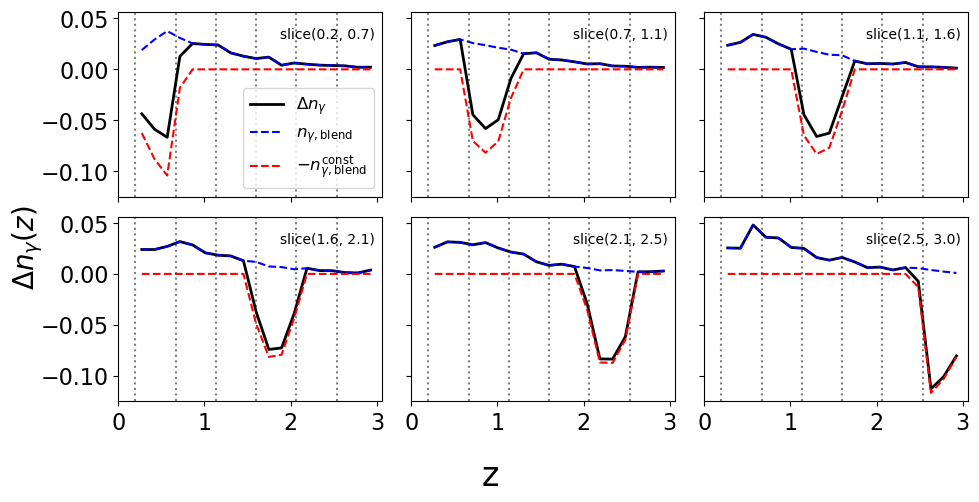

In [9]:
fig,ax = plt.subplots(2,3,figsize=(10,5),sharey=True,sharex=True)
for i in range(len(z_source_bins)):

    for j in range(len(z_source_bins)):
        ax[i//3][i%3].axvline(z_source[j],color='grey',linestyle=':')

    ax[i//3][i%3].plot(z,delta_n[i,:,2],'k',linewidth=2,label=r'$\Delta n_{\gamma}$')
    # ax[i//3][i%3].fill_between(z,delta_n_16[i,:,0,2],delta_n_84[i,:,0,2],color='grey',alpha=0.7)

    ax[i//3][i%3].plot(z,delta_n[i,:,0],'blue',linestyle='--',label=r'$n_{\gamma,{\rm blend}}$')

    ax[i//3][i%3].plot(z,-delta_n[i,:,1],'red',linestyle='--',label=r'$-n_{\gamma,{\rm blend}}^{\rm const}$')

    ax[i//3][i%3].text(1.88,0.03,f'slice({z_source[i]:.1f}, {z_source[i+1]:.1f})')
    ax[i//3][i%3].set_xticks(np.linspace(0.,3.,4))
    ax[i//3][i%3].tick_params(axis='both', labelsize=16)

ax[0][0].legend(fontsize=12)
    
fig.supylabel(r'$\Delta n_{\gamma}(z)$',fontsize=20)
fig.supxlabel('z',fontsize=24)

plt.tight_layout()